# Quantum Repeater Design - Purification Strategy Test Real

## Heralded Quantum Repeater

### Components

* QGen - perform entangled photons/qubits generation
* QSwap - performing quantum entanglement swapping
* Alice - represents sender
* Bob - represents destination/recipient
* QMem - stores qubits awaiting swapping protocol

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import IBMQ, transpile, execute
from qiskit.result import Counts, marginal_counts
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector, state_fidelity, DensityMatrix
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator, AerSimulator
from qiskit.circuit import Instruction, Gate
from qiskit.circuit.library import RXGate
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.quantum_info.analysis import hellinger_fidelity
from qiskit_ibm_runtime import QiskitRuntimeService, Session

In [2]:
# Optional: List all the instances you can access.
service = QiskitRuntimeService(channel='ibm_quantum')
# Get the operational real backends
QiskitRuntimeService().backends(operational=True)

[<IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_nairobi')>]

In [3]:
QiskitRuntimeService().least_busy(operational=True)

<IBMBackend('simulator_extended_stabilizer')>

In [4]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

/tmp/ipykernel_1028/191978293.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


In [5]:
def get_device_noise_model() -> (AerSimulator, NoiseModel):
    backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 1 and
                                       not b.configuration().simulator and b.status().operational==True))
    # backend = QiskitRuntimeService().least_busy(simulator=False, operational=True)
    backend = AerSimulator.from_backend(backend)

    noise_model = NoiseModel.from_backend(backend)
    return backend, noise_model

In [6]:
backend, noise_model = get_device_noise_model()

In [7]:
print("Backend:\n", backend)
print("\nNoise Model:\n", noise_model)

Backend:
 aer_simulator(ibm_lagos)

Noise Model:
 NoiseModel:
  Basis gates: ['break_loop', 'continue_loop', 'cx', 'for_loop', 'id', 'if_else', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'superop', 'sx', 'while_loop', 'x']
  Instructions with noise: ['x', 'cx', 'reset', 'sx', 'measure', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x',

In [8]:
SHOTS = 10000
ITERATIONS_TO_AVG = 20

In [9]:
class QuantumCircuitOperations:
    def __init__(self, barrier: bool = False):
        self.barrier = barrier
    
    def create_random_statevector(self, dimensions: int) -> Statevector:
        return random_statevector(dimensions)
    
    def create_bell_pairs(self, qc: QuantumCircuit, regs: list) -> None:
        if self.barrier: qc.barrier()
        for reg in regs:
            for q in range(reg.size):
                if q % 2 == 0:
                    qc.h(reg[q])
                    qc.cx(reg[q], reg[q + 1])
    
    def bell_state_operation(self, qc: QuantumCircuit, a: list = [QuantumRegister, QuantumRegister]) -> None:
        if self.barrier: qc.barrier()
        qc.cx(a[0], a[1])
        qc.h(a[0])
    
    def bell_state_measurement(self, qc: QuantumCircuit, a: list = [QuantumRegister, QuantumRegister]) -> None:
        if self.barrier: qc.barrier()
        qc.measure(a[0], 0)
        qc.measure(a[1], 1)
    
    def pauli_correction_operation(self, qc: QuantumCircuit, d: QuantumRegister, a: QuantumRegister, b: QuantumRegister, bsm_z: ClassicalRegister, bsm_x: ClassicalRegister) -> None:
        # Apply the gates if the registers are in the state '1'
        if self.barrier: qc.barrier()
        # qc.x(b).c_if(bsm_x, 1)
        # qc.z(b).c_if(bsm_z, 1)
        qc.cx(a, b)
        qc.cz(d, b)

In [10]:
class QuantumVisualizations:
    def display_statevector_as_array(self, psi: Statevector) -> None:
        display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
    
    def display_bloch_statevector(self, psi: Statevector):
        return plot_bloch_multivector(psi)

In [11]:
class QuantumNativeSimulations:
    def statevector_sim(self, qc: QuantumCircuit) -> Statevector:
        # returns the circuit statevector
        state_sim: StatevectorSimulator = StatevectorSimulator()
        return state_sim.run(transpile(qc, state_sim)).result().get_statevector()
    
    def qasm_sim(self, qc: QuantumCircuit) -> Counts:
        qasm_sim: QasmSimulator = QasmSimulator()
        # result = execute(qc, qasm_sim, shots=10240, optimization_level=3).result()
        result = execute(qc, qasm_sim, shots=10240, optimization_level=3,noise_model=noise_model).result()
        return result.get_counts()
        # return qasm_sim.run(transpile(qc, qasm_sim), shots=10240).result().get_counts()
        
    def qc_backend(self, qc: QuantumCircuit, backend) -> Counts:
        t_qc = transpile(qc, backend, optimization_level=3)
        job = backend.run(t_qc)
        print(job)
        job_monitor(job)  # displays job status under cell
        
        exp_result = job.result()
        exp_counts: Counts = exp_result.get_counts(qc)
        print(exp_counts)
        return exp_counts

In [12]:
def get_count_from_duplicate_circuit(c: QuantumCircuit, a: QuantumRegister, b: QuantumRegister) -> (QuantumCircuit,Counts):
    qcn: QuantumCircuit = c.copy(name="qcn")
    qcn.barrier()
    qcn.measure(a, 0)
    qcn.measure(b, 1)
    # qcn_counts: Counts = qns.qasm_sim(qcn)
    qcn_counts: Counts = qns.qc_backend(qcn, backend)
    return (qcn, qcn_counts)

In [13]:
def get_fidelities_dict(dc: dict) -> dict:
    # compare fidelities
    dictlen: int = len(dc)
    dict_fids = {}

    for i in range(dictlen):
        if i == dictlen - 1:
            break
        cur: str = list(dc.keys())[0]
        nxt: str = list(dc.keys())[i + 1]
        fidelity: float = hellinger_fidelity(dc[cur], dc[nxt])
        f = "F("+cur+","+nxt+")"
        dict_fids[f] = fidelity
    return dict_fids

In [14]:
def full_deutsch_purification() -> Gate:
    c = QuantumCircuit(6, name="Full Deutsch")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(np.pi/2), [1])
    c.append(RXGate(-np.pi/2), [2])
    c.append(RXGate(-np.pi/2), [3])
    c.append(RXGate(-np.pi/2), [4])
    c.append(RXGate(-np.pi/2), [5])

    c.cx(0, 2)
    c.cx(0, 4)

    c.cx(1, 5)
    c.cx(1, 3)
    c.to_gate(label="Full Deutsch")
    return c

def quad_deutsch_purification(n: int) -> Gate:
    c = QuantumCircuit(n, name="Quad Deutsch")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(np.pi/2), [1])
    c.append(RXGate(-np.pi/2), [2])
    c.append(RXGate(-np.pi/2), [3])
    
    c.cx(0, 2)
    c.cx(1, 3)
    
    c.to_gate(label="Quad Deutsch")
    return c

def quad_deutsch_purification_mod(n: int) -> Gate:
    c = QuantumCircuit(n, name="Quad Deutsch")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(np.pi/2), [1])
    c.append(RXGate(-np.pi/2), [2])
    c.append(RXGate(-np.pi/2), [3])
    
    c.cx(0, 2)
    c.cx(1, 3)
    
    c.to_gate(label="Quad Deutsch")
    return c

def quad_deutsch_purification_mod2(n: int) -> Gate:
    c = QuantumCircuit(n, name="Quad Deutsch")
    # c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(np.pi), [1])
    c.append(RXGate(-np.pi/2), [2])
    c.append(RXGate(-np.pi/2), [3])
    
    c.cx(0, 2)
    c.cx(1, 3)
    
    c.to_gate(label="Quad Deutsch")
    return c

def quad_deutsch_purification_mod3(n: int) -> Gate:
    c = QuantumCircuit(n, name="Quad Deutsch")
    # c.append(RXGate(np.pi/2), [0])
    # c.append(RXGate(np.pi), [1])
    # c.append(RXGate(-np.pi/2), [2])
    # c.append(RXGate(-np.pi/2), [3])
    
    c.cx(0, 2)
    c.cx(1, 3)
    
    c.to_gate(label="Quad Deutsch")
    return c

def duo_deutsch_purification(n: int) -> Gate:
    c = QuantumCircuit(n, name="Duo Deutsch")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(-np.pi/2), [1])
    
    c.cx(0, 1)
    
    c.to_gate(label="Duo Deutsch")
    return c

def duo_deutsch_purification_mod(n: int) -> Gate:
    c = QuantumCircuit(n, name="Duo Deutsch")
    # c.append(RXGate(np.pi/2), [0])
    # c.append(RXGate(-np.pi/2), [1])
    
    c.cx(0, 1)
    
    c.to_gate(label="Duo Deutsch")
    return c

In [15]:
qco: QuantumCircuitOperations = QuantumCircuitOperations(True)
qns: QuantumNativeSimulations = QuantumNativeSimulations()
qv: QuantumVisualizations = QuantumVisualizations()

dict_counts: dict= {}

In [16]:
def fidelity_analysis(strategy: str = None) -> (QuantumCircuit, Counts) :
    alice: QuantumRegister = QuantumRegister(2, "alice")
    charlie: QuantumRegister = QuantumRegister(2, "charlie")
    bob: QuantumRegister = QuantumRegister(2, "bob")

    bsm_z: ClassicalRegister = ClassicalRegister(1, "bsm_zresult")
    bsm_x: ClassicalRegister = ClassicalRegister(1, "bsm_xresult")

    # coz: ClassicalRegister = ClassicalRegister(1, "coz")
    # cox: ClassicalRegister = ClassicalRegister(1, "cox")

    qc: QuantumCircuit = QuantumCircuit(alice, charlie, bob, bsm_z, bsm_x)#, coz, cox)
    
    # dict_counts.clear()
    
    psi: Statevector = qco.create_random_statevector(2)
    init_instruction: Initialize = Initialize(psi)
    init_instruction.label = "init instruction"
    qc.append(init_instruction, [alice[0]])
    # qc.append(init_instruction, [bob[1]])
    
    qco.create_bell_pairs(qc, [alice, charlie, bob])
    
    ############################################################################################################
    ###########################################################################################################
    # PURIFICATION AFTER BELL PAIR CREATION
    if strategy == "abpc" or strategy == "cust":
        qc.barrier()
        # qc.append( quad_deutsch_purification(4), [alice[0], alice[1], charlie[0], charlie[1]] )
        qc.append( full_deutsch_purification(), [alice[0], alice[1], charlie[0], charlie[1], bob[0], bob[1]] )
        # qc.append(RXGate(-np.pi/4), [alice[1]])
        qc.barrier()
        
        
    
#     # count after bell pair creation
    qc_abpc, count_abpc = get_count_from_duplicate_circuit(qc, alice[0], alice[1])
    dict_counts["abpc"].append(count_abpc)# = count_abpc
    
    # count after entanglement after distribution/transmission
    qc_dist, count_dist = get_count_from_duplicate_circuit(qc, alice[0], alice[1])
    dict_counts["dist"].append(count_dist)# = count_dist
    
    # Swap Protocol Stage 1
    if strategy == "swapalt":
        qc.barrier()
        qc.append( quad_deutsch_purification(4), [alice[0], alice[1], charlie[0], charlie[1]] )
        # qc.append( full_deutsch_purification(), [alice[0], alice[1], charlie[0], charlie[1], bob[0], bob[1]] )
        qc.barrier()
        
    qco.bell_state_operation(qc, [alice[1], charlie[0]])
    # qco.bell_state_measurement(qc, [alice[1], charlie[0]])
    qco.pauli_correction_operation(qc, alice[0], alice[1], charlie[1], bsm_z, bsm_x)
    
    ########################################################################################
    #######################################################################################
    # PURIFICATION AFTER FIRST SWAP PROTOCOL
     # purification after bell pair creation after first swap protocol
    if strategy == "cust"  or strategy == "swapalt":
        qc.barrier()
        qc.append( quad_deutsch_purification_mod2(4), [alice[0], charlie[1], bob[0], bob[1]] )
        # qc.append( full_deutsch_purification(), [alice[0], alice[1], charlie[0], charlie[1], bob[0], bob[1]] )
        qc.barrier()
        
    if strategy == "aswap1" or strategy == "swap" or strategy == "cust":
        qc.barrier()
        qc.append( quad_deutsch_purification(4), [alice[0], charlie[1], bob[0], bob[1]] )
        qc.barrier()
        
    if strategy == "swaploop":
        qc.barrier()
        # for i in range(2):
        qc.append( quad_deutsch_purification(4), [alice[0], charlie[1], bob[0], bob[1]] )
        qc.append( quad_deutsch_purification_mod3(4), [alice[0], charlie[1], bob[0], bob[1]] )
        qc.barrier()
        
    # count after first stage swap
    qc_aswap1, count_aswap1 = get_count_from_duplicate_circuit(qc, alice[0], charlie[1])
    dict_counts["aswap1"].append(count_aswap1)# = count_aswap

    # # Swap Protocol Stage 2
    if strategy == "swapalt":
        qc.barrier()
        qc.append( quad_deutsch_purification_mod3(4), [alice[0], charlie[1], bob[0], bob[1]] )
        qc.barrier()
        
    qco.bell_state_operation(qc, [charlie[1], bob[0]])
    # qco.bell_state_measurement(qc, [charlie[1], bob[0]])
    qco.pauli_correction_operation(qc, alice[0], charlie[1], bob[1], bsm_z, bsm_x)
    
    ############################################################################################
    ###########################################################################################
    # PURIFICATION AFTER SECOND SWAP PROTOCOL
    if strategy == "swap" or strategy == "swapalt":# or strategy == "aswap2"  or strategy == "cust":
        qc.barrier()
        qc.append( duo_deutsch_purification_mod(2), [alice[0], bob[1]] )
        qc.barrier()
        
    if strategy == "swaploop":
        qc.barrier()
        for i in range(2):
            qc.append( duo_deutsch_purification_mod(2), [alice[0], bob[1]] )
        qc.barrier()
        
    # count after second stage swap
    qc_aswap2, count_aswap2 = get_count_from_duplicate_circuit(qc, alice[0], bob[1])
    dict_counts["aswap2"].append(count_aswap2)# = count_aswap
    
    qc.barrier()
    qc.cx(alice[0], bob[1])
    qc.h(alice[0])
    
    # 
    inverse_init_instruction: Initialize = init_instruction.gates_to_uncompute()
    qc.append(inverse_init_instruction, [alice[0]])
    # qc.append(inverse_init_instruction, [bob[1]])
    
    qc.barrier()
    qc.measure(alice[0], bsm_z)
    qc.measure(bob[1], bsm_x)

    # Execute on Backend
    # counts: Counts = qns.qasm_sim(qc)
    counts: Counts = qns.qc_backend(qc, backend)
    
    dict_counts["count_end"].append(counts)# = counts
    
    return (qc, counts)

### Without Purification - Null Purification

Job Status: job has successfully run
{'0 1': 17, '1 1': 361, '1 0': 34, '0 0': 612}
Job Status: job has successfully run
{'0 1': 31, '1 1': 361, '1 0': 22, '0 0': 610}
Job Status: job has successfully run
{'0 1': 190, '1 1': 201, '1 0': 333, '0 0': 300}
Job Status: job has successfully run
{'0 1': 184, '1 1': 204, '0 0': 327, '1 0': 309}
Job Status: job has successfully run
{'1 1': 210, '0 1': 249, '1 0': 279, '0 0': 286}
Job Status: job has successfully run
{'0 1': 28, '1 0': 29, '0 0': 368, '1 1': 599}
Job Status: job has successfully run
{'0 1': 16, '1 0': 21, '0 0': 388, '1 1': 599}
Job Status: job has successfully run
{'0 1': 306, '0 0': 211, '1 0': 193, '1 1': 314}
Job Status: job has successfully run
{'1 1': 295, '1 0': 220, '0 0': 234, '0 1': 275}
Job Status: job has successfully run
{'1 1': 237, '1 0': 251, '0 0': 259, '0 1': 277}
Job Status: job has successfully run
{'0 1': 26, '1 0': 45, '0 0': 162, '1 1': 791}
Job Status: job has successfully run
{'0 1': 25, '1 1': 792, '0 

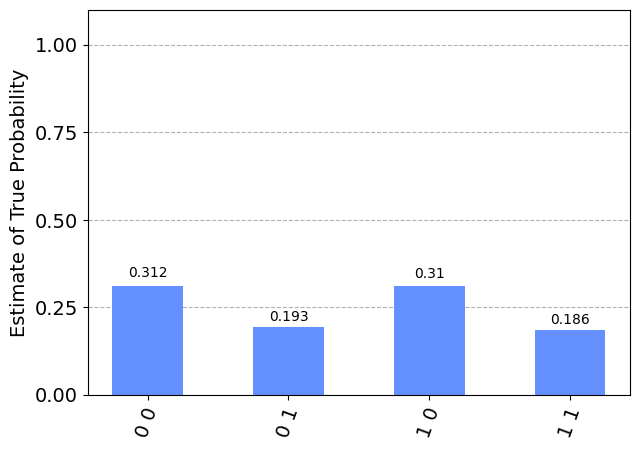

In [17]:
dict_counts.clear()
dict_counts["abpc"] = []
dict_counts["dist"] = []
dict_counts["aswap1"] = []
dict_counts["aswap2"] = []
dict_counts["count_end"] = []


d = []
for i in range(ITERATIONS_TO_AVG):
    circ, counts = fidelity_analysis()
    d.append(counts)

counts = dict( pd.DataFrame(d).mean() )

stage_counts: dict = {
    "abpc": dict( pd.DataFrame(dict_counts["abpc"]).mean() ),
    "dist": dict( pd.DataFrame(dict_counts["dist"]).mean() ),
    "aswap1": dict( pd.DataFrame(dict_counts["aswap1"]).mean() ),
    "aswap2": dict( pd.DataFrame(dict_counts["aswap2"]).mean() ),
    "count_end": dict( pd.DataFrame(dict_counts["count_end"]).mean() ),
}

print(counts)
print(" ")
# print(dict_counts)
# print(" ")
# print(dict( pd.DataFrame(dict_counts["abpc"]).mean()))
# print(" ")
# print(dict( pd.DataFrame(dict_counts["count_end"]).mean()))

print(stage_counts)

dict_fids_wp: dict = get_fidelities_dict(stage_counts)#dict_counts)

graph = plot_histogram(counts)#, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

dx = graph.axes[0]
dx.set_ylim(0, 1.1)
dx.set_ylabel("Estimate of True Probability")

display( graph )

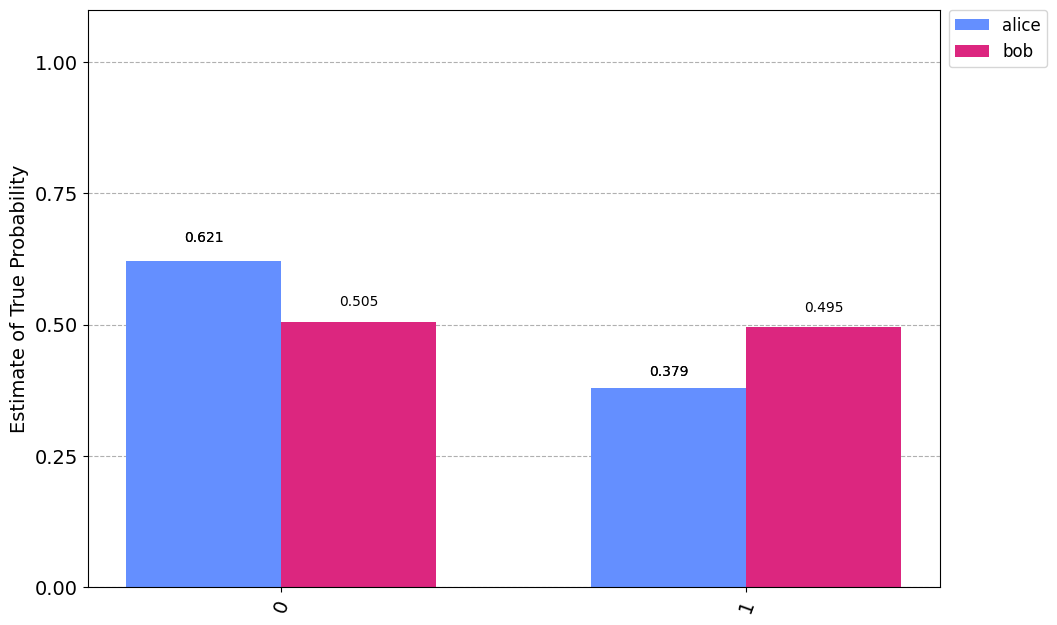

In [18]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
legend: list = ["alice", "bob"]
graph = plot_histogram(qubit_counts, legend=legend, figsize=(11.0,7.5))#, title="Verification of Entanglement Swapping between Alice and Bob")
dx = graph.axes[0]
dx.set_ylim(0, 1.1)
dx.set_ylabel("Estimate of True Probability")
display( graph )

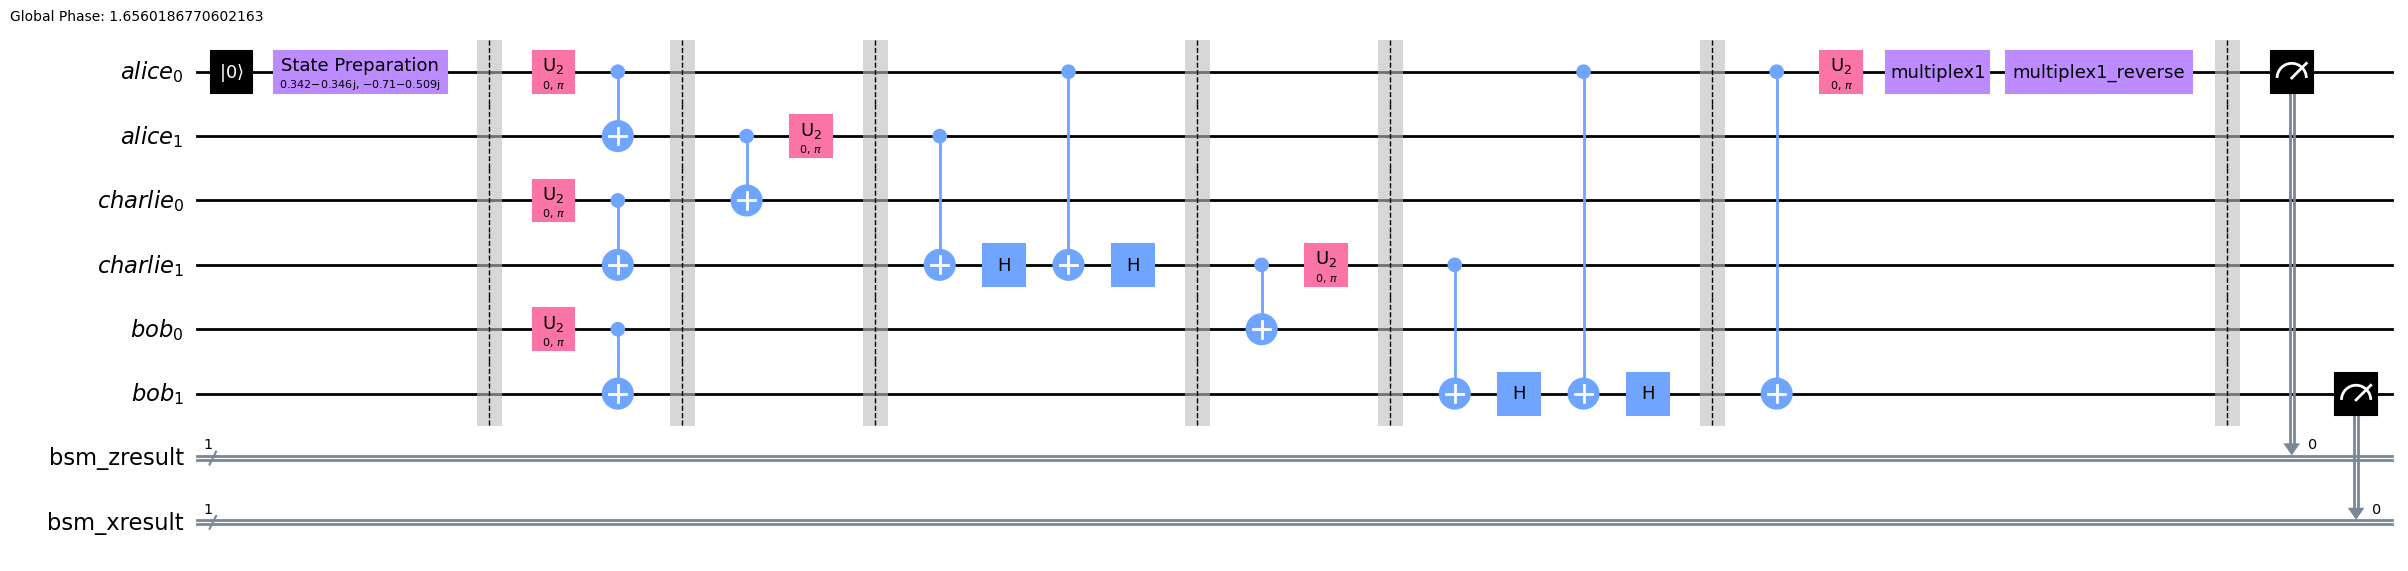

In [19]:
circ.decompose().draw("mpl", fold=-1)

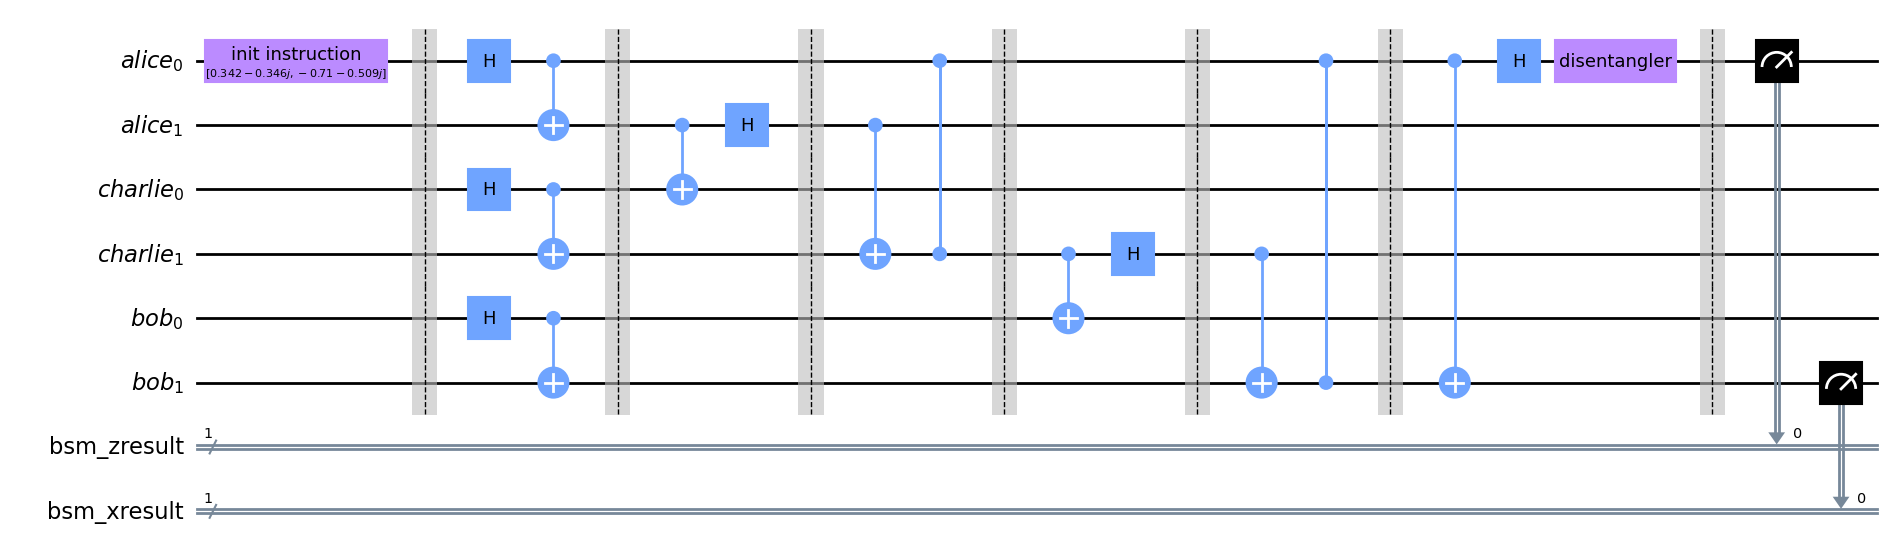

In [20]:
circ.draw("mpl", fold=-1)

### With Purification After Bell-pair production - Post Bell_pair pruduction purification

In [21]:
# circ, counts = fidelity_analysis("abpc")
# # dict_counts_wp: dict = dict_counts
# dict_fids_abpc: dict = get_fidelities_dict(dict_counts)
# plot_histogram(counts)#, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

# dict_counts.clear()
# dict_counts["abpc"] = []
# dict_counts["dist"] = []
# dict_counts["aswap1"] = []
# dict_counts["aswap2"] = []
# dict_counts["count_end"] = []

# d = []
# for i in range(ITERATIONS_TO_AVG):
#     circ, counts = fidelity_analysis("abpc")
#     d.append(counts)

# counts = dict( pd.DataFrame(d).mean() )

# stage_counts: dict = {
#     "abpc": dict( pd.DataFrame(dict_counts["abpc"]).mean() ),
#     "dist": dict( pd.DataFrame(dict_counts["dist"]).mean() ),
#     "aswap1": dict( pd.DataFrame(dict_counts["aswap1"]).mean() ),
#     "aswap2": dict( pd.DataFrame(dict_counts["aswap2"]).mean() ),
#     "count_end": dict( pd.DataFrame(dict_counts["count_end"]).mean() ),
# }

# dict_fids_abpc: dict = get_fidelities_dict(stage_counts)

# graph = plot_histogram(counts)

# dx = graph.axes[0]
# dx.set_ylim(0, 1.1)
# dx.set_ylabel("Estimate of True Probability")

# display( graph )

In [22]:
# graph.savefig("dps_measurement_post_bell_pair.jpg", dpi=500)

In [23]:
# qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
# legend: list = ["alice", "bob"]
# graph = plot_histogram(qubit_counts, legend=legend, figsize=(11.0,7.5) )#, title="Verification of Entanglement Swapping between Alice and Bob")
# dx = graph.axes[0]
# dx.set_ylim(0, 1.1)
# dx.set_ylabel("Estimate of True Probability")
# display( graph )

In [24]:
# graph.savefig("dps_verification_post_bell_pair.jpg", dpi=500)

In [25]:
# circ.draw("mpl", fold=-1)
# circ.decompose().draw("mpl", fold=-1)

### With Purification After Every Swap - Post Swap Purification

Job Status: job has successfully run
{'0 1': 32, '1 1': 97, '1 0': 23, '0 0': 872}
Job Status: job has successfully run
{'0 1': 18, '1 1': 116, '1 0': 18, '0 0': 872}
Job Status: job has successfully run
{'0 1': 259, '1 1': 246, '0 0': 266, '1 0': 253}
Job Status: job has successfully run
{'1 1': 243, '0 0': 272, '1 0': 265, '0 1': 244}
Job Status: job has successfully run
{'0 1': 237, '0 0': 265, '1 0': 263, '1 1': 259}
Job Status: job has successfully run
{'0 1': 14, '1 1': 330, '1 0': 27, '0 0': 653}
Job Status: job has successfully run
{'0 1': 21, '1 1': 330, '1 0': 24, '0 0': 649}
Job Status: job has successfully run
{'0 1': 244, '1 1': 260, '0 0': 272, '1 0': 248}
Job Status: job has successfully run
{'0 1': 249, '1 1': 215, '1 0': 285, '0 0': 275}
Job Status: job has successfully run
{'1 1': 247, '0 0': 272, '1 0': 247, '0 1': 258}
Job Status: job has successfully run
{'0 1': 27, '1 1': 868, '1 0': 20, '0 0': 109}
Job Status: job has successfully run
{'0 1': 18, '0 0': 100, '1 0

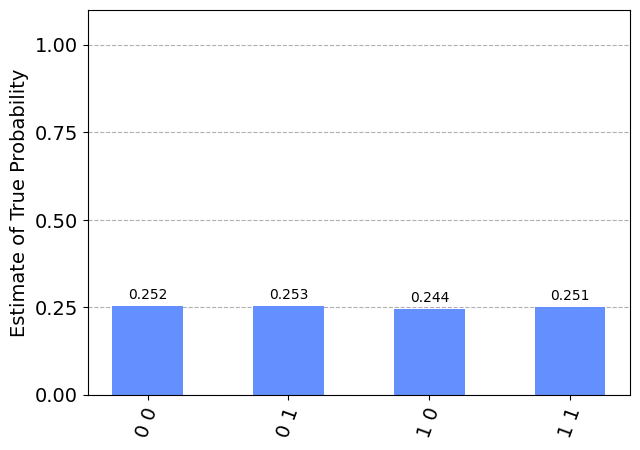

In [26]:
dict_counts.clear()
dict_counts["abpc"] = []
dict_counts["dist"] = []
dict_counts["aswap1"] = []
dict_counts["aswap2"] = []
dict_counts["count_end"] = []

d = []
for i in range(ITERATIONS_TO_AVG):
    circ, counts = fidelity_analysis("swap")
    d.append(counts)

counts = dict( pd.DataFrame(d).mean() )

stage_counts: dict = {
    "abpc": dict( pd.DataFrame(dict_counts["abpc"]).mean() ),
    "dist": dict( pd.DataFrame(dict_counts["dist"]).mean() ),
    "aswap1": dict( pd.DataFrame(dict_counts["aswap1"]).mean() ),
    "aswap2": dict( pd.DataFrame(dict_counts["aswap2"]).mean() ),
    "count_end": dict( pd.DataFrame(dict_counts["count_end"]).mean() ),
}

dict_fids_swap: dict = get_fidelities_dict(stage_counts)

graph = plot_histogram(counts)#, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

dx = graph.axes[0]
dx.set_ylim(0, 1.1)
dx.set_ylabel("Estimate of True Probability")

display( graph )

In [27]:
graph.savefig("dps_measurement_post_swap.jpg", dpi=500)

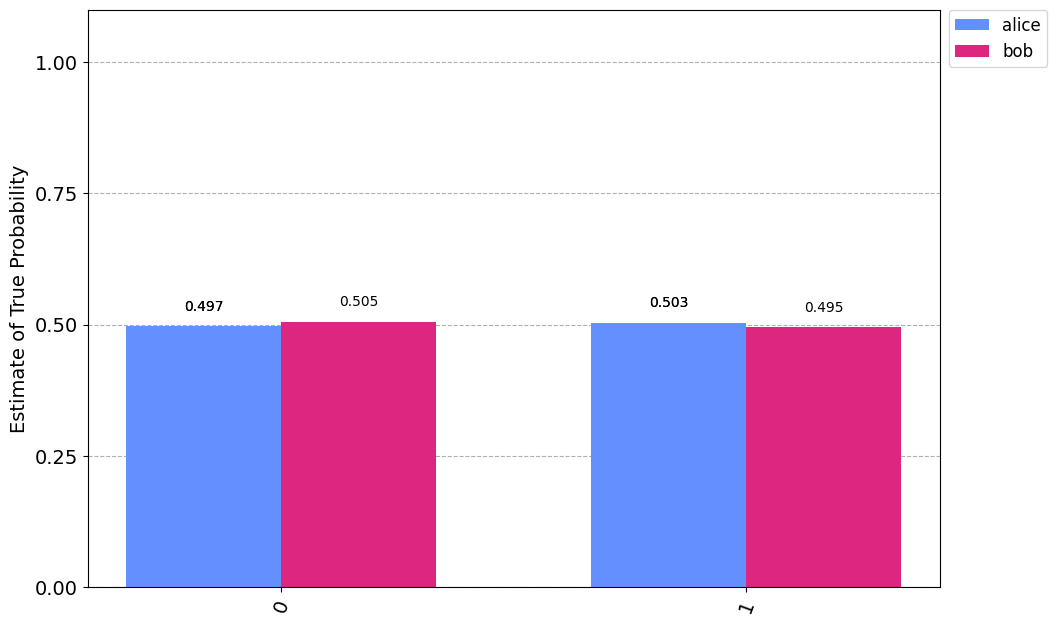

In [28]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
legend: list = ["alice", "bob"]
graph = plot_histogram(qubit_counts, legend=legend, figsize=(11.0,7.5))#, title="Verification of Entanglement Swapping between Alice and Bob")
dx = graph.axes[0]
dx.set_ylim(0, 1.1)
dx.set_ylabel("Estimate of True Probability")
display( graph )

In [29]:
graph.savefig("dps_verification_post_swap.jpg", dpi=500)

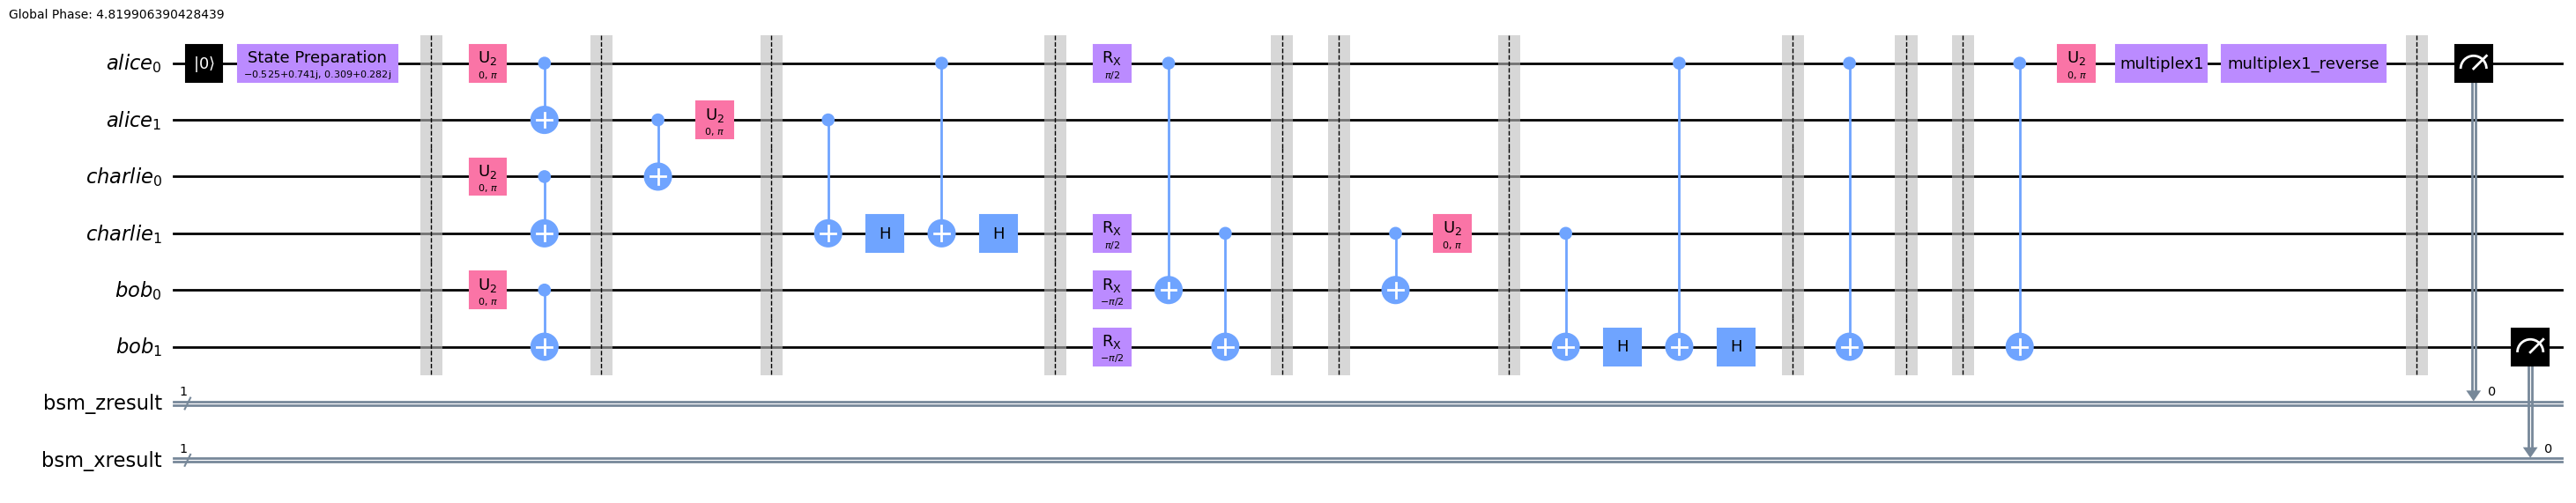

In [30]:
circ.decompose().draw("mpl", fold=-1)

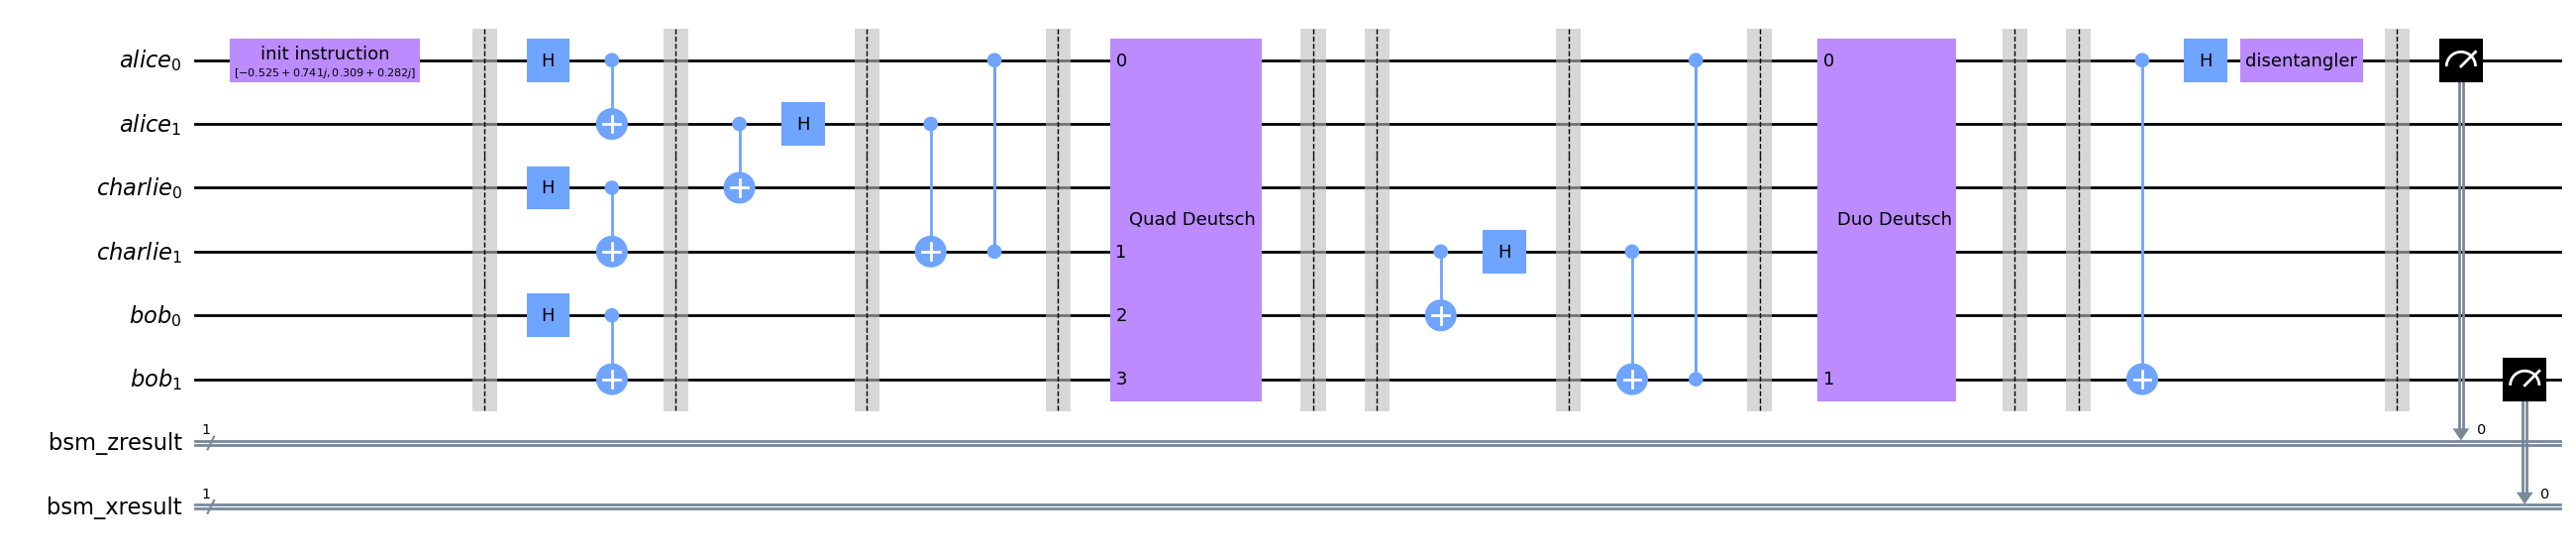

In [31]:
circ.draw("mpl", fold=-1)

### With Repeated Purification After Every Swap - Repeated Post Swap Purification

Job Status: job has successfully run
{'1 0': 23, '0 0': 292, '0 1': 24, '1 1': 685}
Job Status: job has successfully run
{'1 0': 22, '0 0': 293, '0 1': 27, '1 1': 682}
Job Status: job has successfully run
{'1 1': 244, '1 0': 275, '0 0': 254, '0 1': 251}
Job Status: job has successfully run
{'0 1': 258, '0 0': 220, '1 0': 295, '1 1': 251}
Job Status: job has successfully run
{'0 1': 239, '1 1': 261, '0 0': 257, '1 0': 267}
Job Status: job has successfully run
{'0 1': 23, '1 0': 26, '0 0': 187, '1 1': 788}
Job Status: job has successfully run
{'0 1': 30, '1 0': 39, '0 0': 181, '1 1': 774}
Job Status: job has successfully run
{'1 0': 261, '0 0': 267, '0 1': 263, '1 1': 233}
Job Status: job has successfully run
{'1 1': 252, '0 0': 273, '1 0': 275, '0 1': 224}
Job Status: job has successfully run
{'1 1': 296, '0 1': 264, '0 0': 240, '1 0': 224}
Job Status: job has successfully run
{'0 1': 32, '1 1': 505, '0 0': 445, '1 0': 42}
Job Status: job has successfully run
{'0 1': 21, '1 0': 24, '0 0

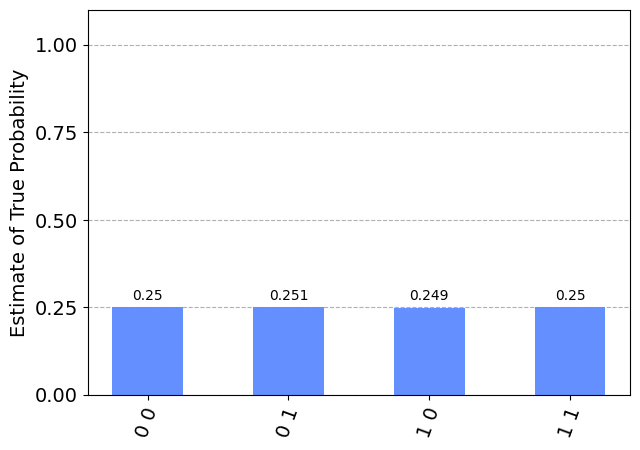

In [32]:
dict_counts.clear()
dict_counts["abpc"] = []
dict_counts["dist"] = []
dict_counts["aswap1"] = []
dict_counts["aswap2"] = []
dict_counts["count_end"] = []

d = []
for i in range(ITERATIONS_TO_AVG):
    circ, counts = fidelity_analysis("swaploop")
    d.append(counts)

counts = dict( pd.DataFrame(d).mean() )

stage_counts: dict = {
    "abpc": dict( pd.DataFrame(dict_counts["abpc"]).mean() ),
    "dist": dict( pd.DataFrame(dict_counts["dist"]).mean() ),
    "aswap1": dict( pd.DataFrame(dict_counts["aswap1"]).mean() ),
    "aswap2": dict( pd.DataFrame(dict_counts["aswap2"]).mean() ),
    "count_end": dict( pd.DataFrame(dict_counts["count_end"]).mean() ),
}

dict_fids_swaploop: dict = get_fidelities_dict(stage_counts)

graph = plot_histogram(counts)

dx = graph.axes[0]
dx.set_ylim(0, 1.1)
dx.set_ylabel("Estimate of True Probability")

display( graph )

In [33]:
graph.savefig("dps_measurement_repeated_post_swap.jpg", dpi=500)

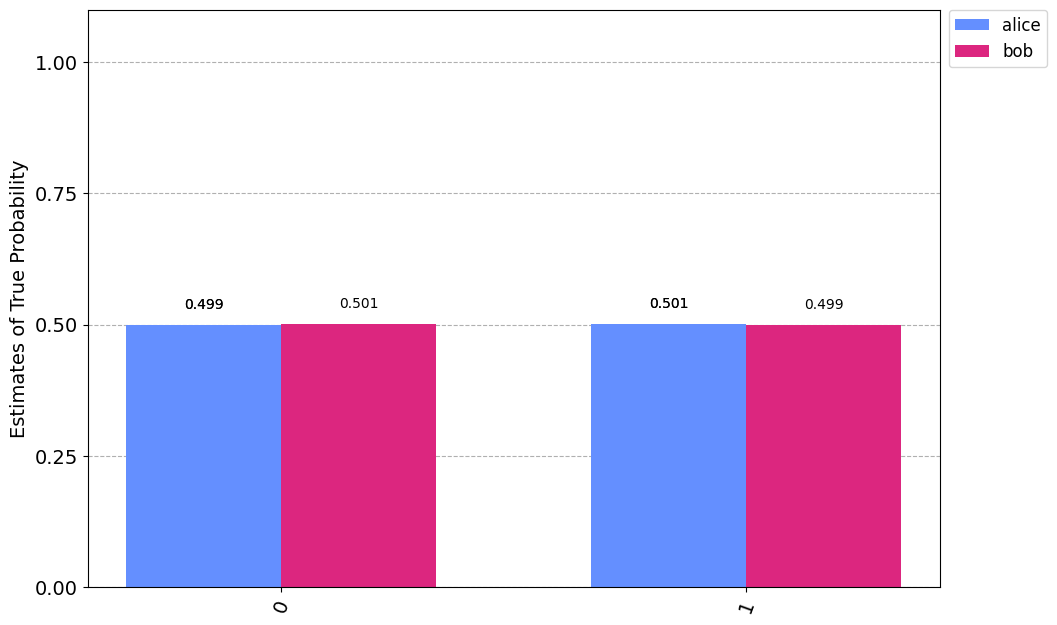

In [34]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
legend: list = ["alice", "bob"]
graph = plot_histogram(qubit_counts, legend=legend, figsize=(11.0,7.5))#, title="Verification of Entanglement Swapping between Alice and Bob")
dx = graph.axes[0]
dx.set_ylim(0, 1.1)
dx.set_ylabel("Estimates of True Probability")
display( graph )

In [35]:
graph.savefig("dps_verification_repeated_post_swap.jpg", dpi=500)

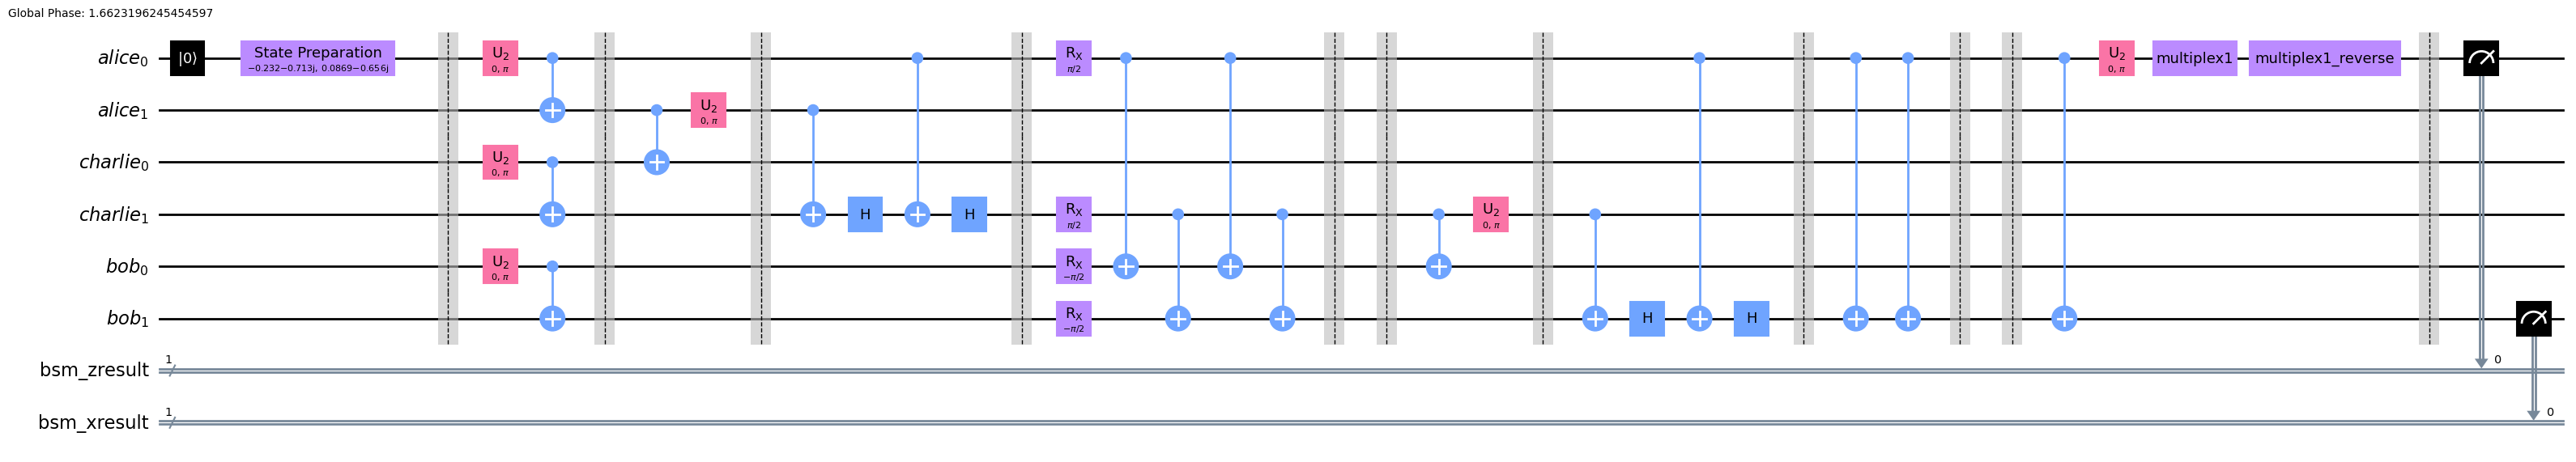

In [36]:
circ.decompose().draw("mpl", fold=-1)

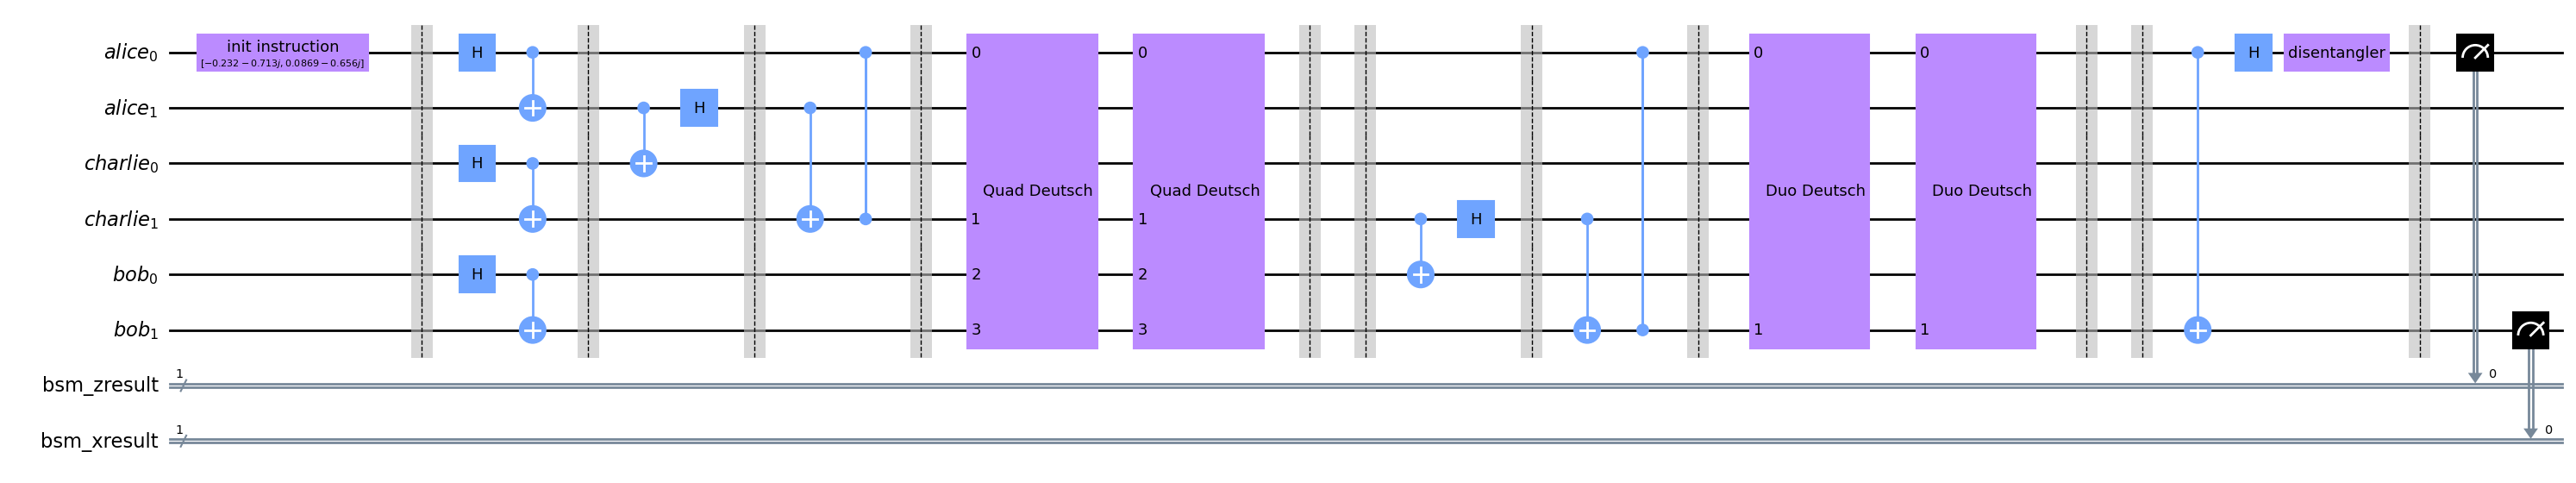

In [37]:
circ.draw("mpl", fold=-1)

### With Purification Before and After Every Swap - Alternating Purification Protocols - Pre and Post Swap Purification

Job Status: job has successfully run
{'0 1': 22, '1 1': 596, '1 0': 20, '0 0': 386}
Job Status: job has successfully run
{'0 1': 18, '1 0': 21, '0 0': 344, '1 1': 641}
Job Status: job has successfully run
{'1 1': 238, '1 0': 270, '0 0': 279, '0 1': 237}
Job Status: job has successfully run
{'1 1': 236, '0 1': 238, '1 0': 259, '0 0': 291}
Job Status: job has successfully run
{'1 0': 257, '0 0': 244, '1 1': 251, '0 1': 272}
Job Status: job has successfully run
{'1 1': 30, '0 1': 12, '1 0': 28, '0 0': 954}
Job Status: job has successfully run
{'0 1': 14, '1 1': 40, '1 0': 29, '0 0': 941}
Job Status: job has successfully run
{'0 1': 251, '1 1': 219, '0 0': 284, '1 0': 270}
Job Status: job has successfully run
{'1 1': 240, '0 1': 264, '1 0': 262, '0 0': 258}
Job Status: job has successfully run
{'1 1': 252, '0 0': 254, '1 0': 265, '0 1': 253}
Job Status: job has successfully run
{'0 1': 30, '1 0': 19, '0 0': 415, '1 1': 560}
Job Status: job has successfully run
{'0 1': 31, '1 0': 23, '0 0':

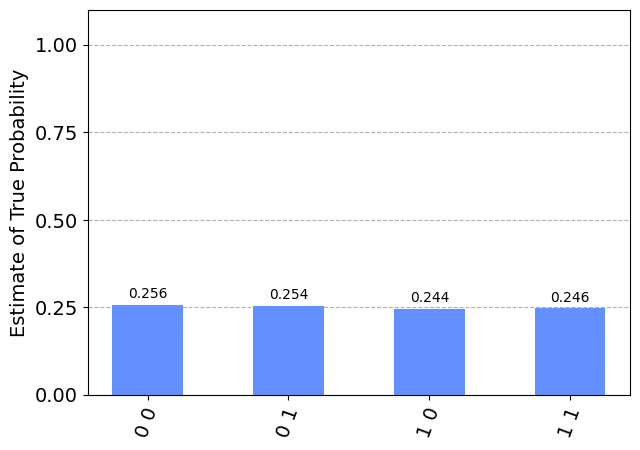

In [38]:
dict_counts.clear()
dict_counts["abpc"] = []
dict_counts["dist"] = []
dict_counts["aswap1"] = []
dict_counts["aswap2"] = []
dict_counts["count_end"] = []

d = []
for i in range(ITERATIONS_TO_AVG):
    circ, counts = fidelity_analysis("swapalt")
    d.append(counts)

counts = dict( pd.DataFrame(d).mean() )

stage_counts: dict = {
    "abpc": dict( pd.DataFrame(dict_counts["abpc"]).mean() ),
    "dist": dict( pd.DataFrame(dict_counts["dist"]).mean() ),
    "aswap1": dict( pd.DataFrame(dict_counts["aswap1"]).mean() ),
    "aswap2": dict( pd.DataFrame(dict_counts["aswap2"]).mean() ),
    "count_end": dict( pd.DataFrame(dict_counts["count_end"]).mean() ),
}

dict_fids_swapalt: dict = get_fidelities_dict(stage_counts)

graph = plot_histogram(counts)

dx = graph.axes[0]
dx.set_ylim(0, 1.1)
dx.set_ylabel("Estimate of True Probability")

display( graph )

In [39]:
graph.savefig("dps_measurement_pre_and_post_swap.jpg", dpi=500)

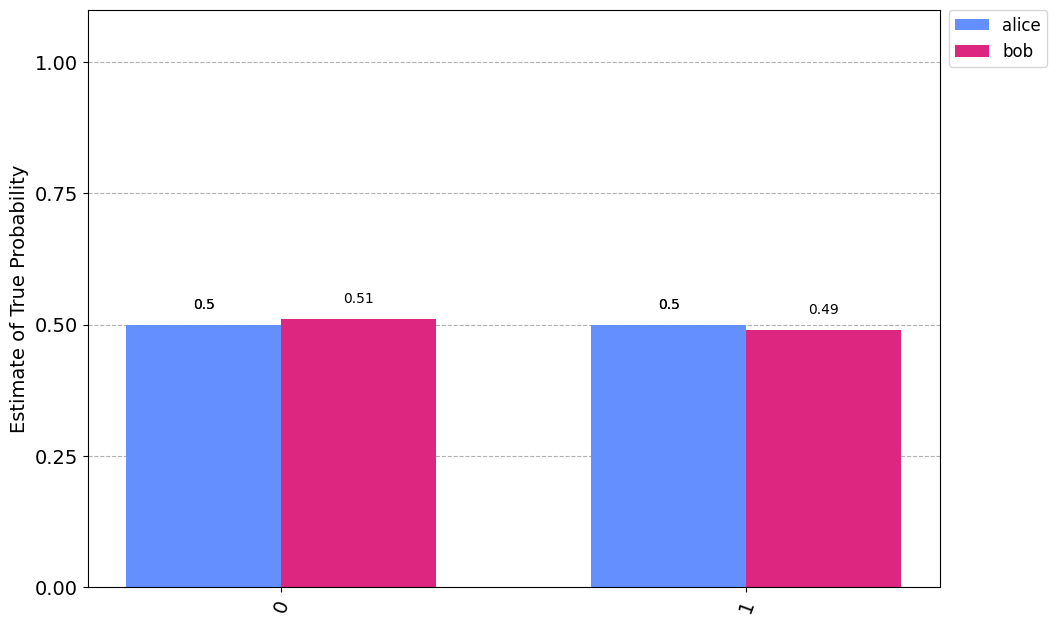

In [40]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
legend: list = ["alice", "bob"]
graph = plot_histogram(qubit_counts, legend=legend, figsize=(11.0,7.5))#, title="Verification of Entanglement Swapping between Alice and Bob")
dx = graph.axes[0]
dx.set_ylim(0, 1.1)
dx.set_ylabel("Estimate of True Probability")
display( graph )

In [41]:
graph.savefig("dps_verification_pre_and_post_swap.jpg", dpi=500)

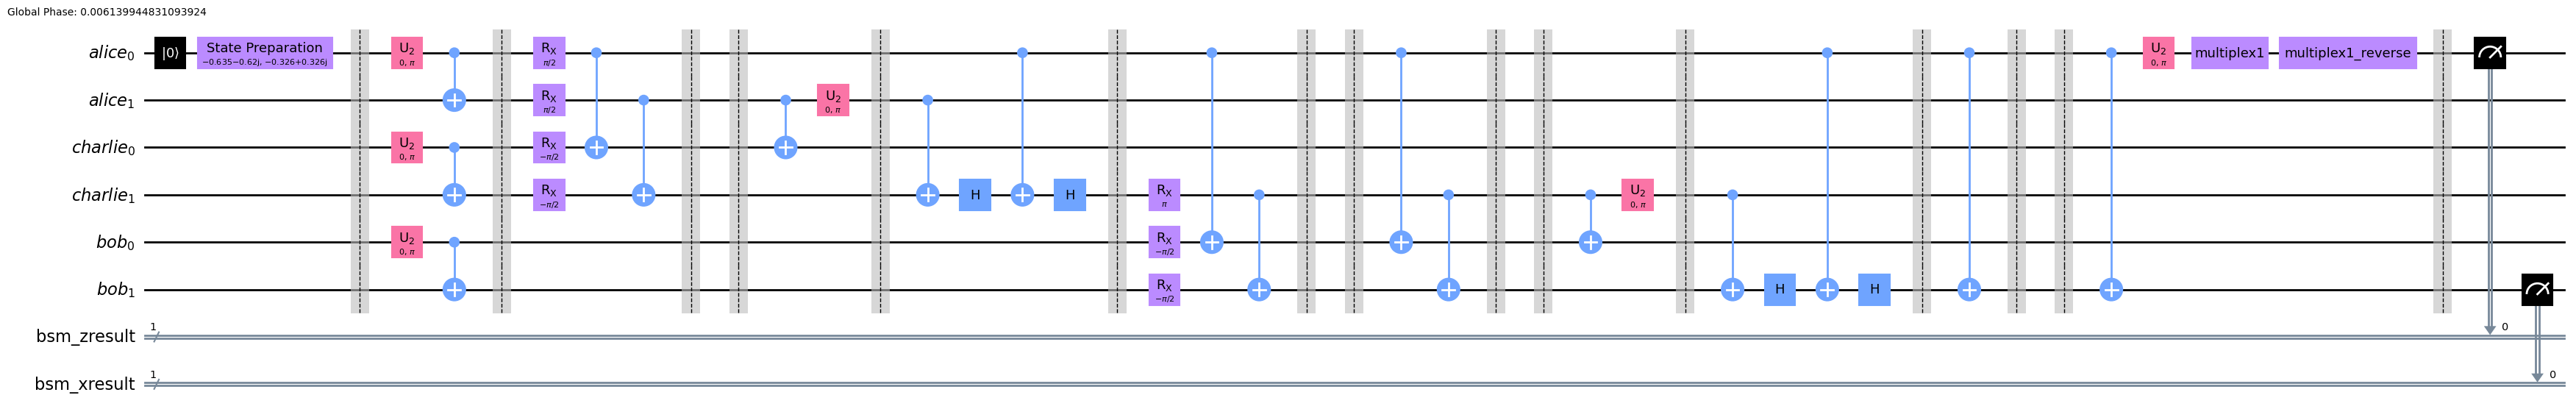

In [42]:
circ.decompose().draw("mpl", fold=-1)

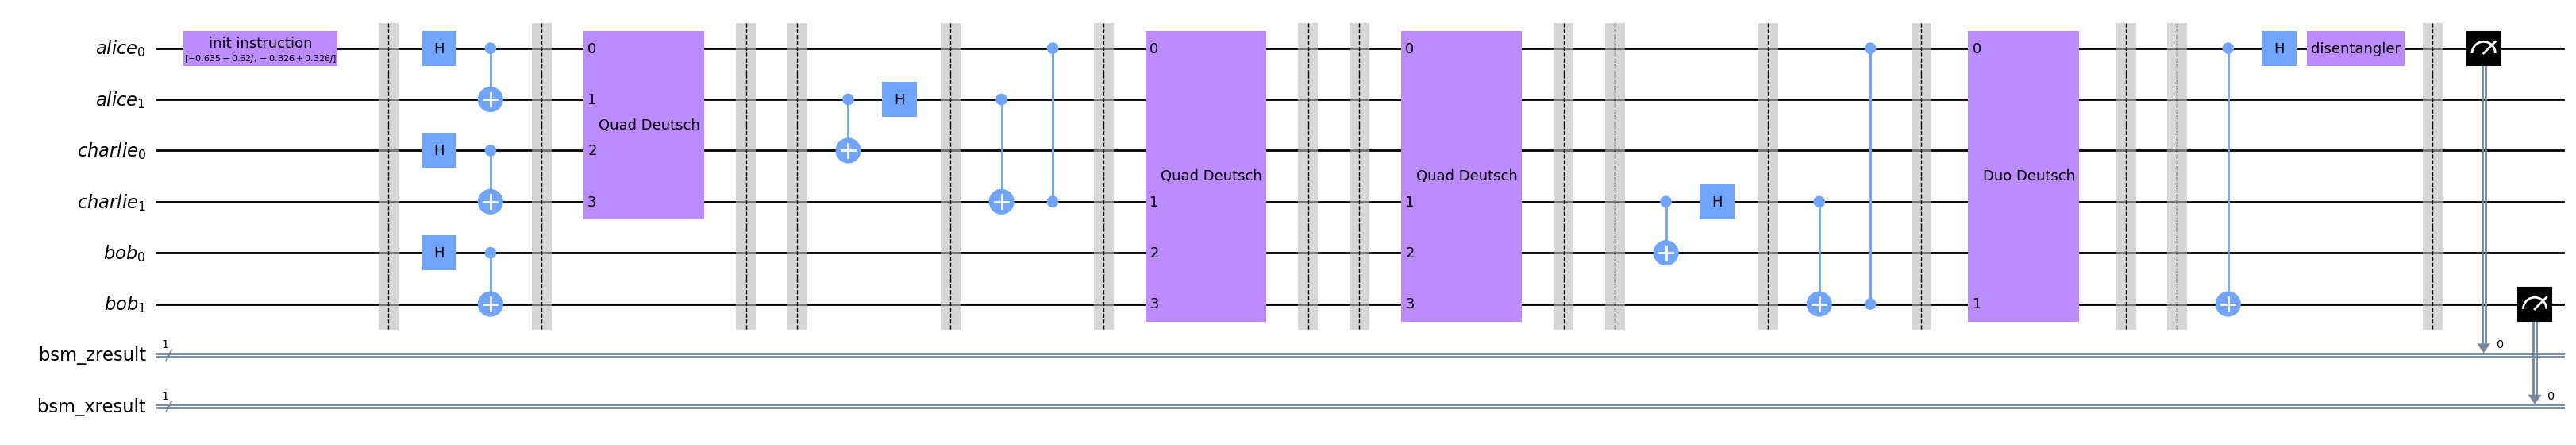

In [43]:
circ.draw("mpl", fold=-1)

### Suitable Purification Strategy - Custom Solution

In [44]:
# dict_counts.clear()
# dict_counts["abpc"] = []
# dict_counts["dist"] = []
# dict_counts["aswap1"] = []
# dict_counts["aswap2"] = []
# dict_counts["count_end"] = []

# d = []
# for i in range(ITERATIONS_TO_AVG):
#     circ, counts = fidelity_analysis("cust")
#     d.append(counts)

# counts = dict( pd.DataFrame(d).mean() )

# stage_counts: dict = {
#     "abpc": dict( pd.DataFrame(dict_counts["abpc"]).mean() ),
#     "dist": dict( pd.DataFrame(dict_counts["dist"]).mean() ),
#     "aswap1": dict( pd.DataFrame(dict_counts["aswap1"]).mean() ),
#     "aswap2": dict( pd.DataFrame(dict_counts["aswap2"]).mean() ),
#     "count_end": dict( pd.DataFrame(dict_counts["count_end"]).mean() ),
# }

# dict_fids_swapcust: dict = get_fidelities_dict(stage_counts)

# graph = plot_histogram(counts)

# dx = graph.axes[0]
# dx.set_ylim(0, 1.1)
# dx.set_ylabel("Estimate of True Probability")

# display( graph )

In [45]:
# qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(0, 2)]
# legend: list = ["alice", "bob"]
# graph = plot_histogram(qubit_counts, legend=legend, figsize=(11.0,7.5))#, title="Verification of Entanglement Swapping between Alice and Bob")
# dx = graph.axes[0]
# dx.set_ylim(0, 1.1)
# dx.set_ylabel("Estimate of True Probability")
# display( graph )

In [46]:
# circ.draw("mpl", fold=-1)
# circ.decompose().draw("mpl", fold=-1)

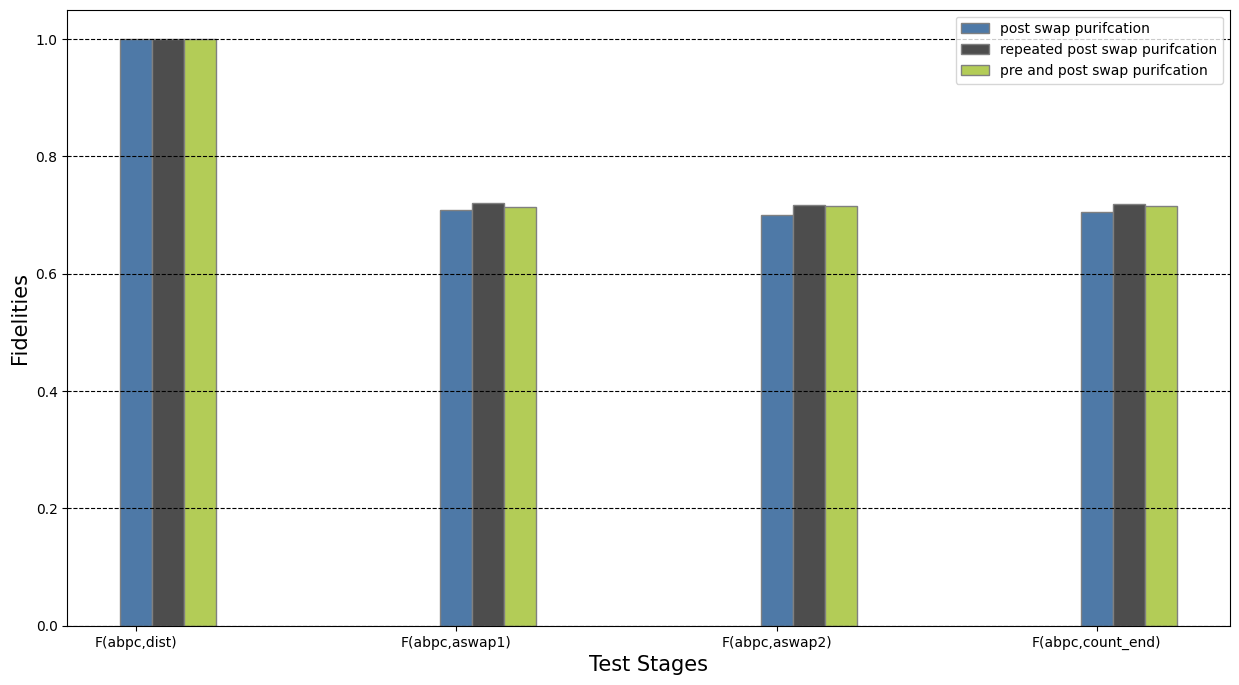

In [47]:
barwidth = 0.10
# fig = plt.figure(figsize = (10, 5))
fig = plt.subplots(figsize =(15, 8))#, dpi=500)

x_axis = np.arange(len(dict_fids_wp))

#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"]
#115f9a", "#1984c5", "#22a7f0", "#48b5c4", "#76c68f", "#a6d75b", "#c9e52f", "#d0ee11", "#d0f400"]


# without purification
# x = list(dict_fids_wp.keys())
# y = list(dict_fids_wp.values())
# plt.bar(x_axis, y, width=barwidth, color="#115f9a", edgecolor="grey", label="without purifcation")

# with purification after bell pair creation
# x = list(dict_fids_abpc.keys())
# y = list(dict_fids_abpc.values())
# plt.bar( x_axis, y, width=barwidth, color="#0070fb", edgecolor="grey", label="post bell-pair creation purification")

# with purification after every swap
x = list(dict_fids_swap.keys())
y = list(dict_fids_swap.values())
plt.bar( [k + 1*barwidth for k in x_axis], y, width=barwidth, color="#4e79a7", edgecolor="grey", label="post swap purifcation")

# with repeated purification after every swap
x = list(dict_fids_swaploop.keys())
y = list(dict_fids_swaploop.values())
plt.bar( [k + 2*barwidth for k in x_axis], y, width=barwidth, color="#4d4d4d", edgecolor="grey", label="repeated post swap purifcation")

# with alternating purification with every swap
x = list(dict_fids_swapalt.keys())
y = list(dict_fids_swapalt.values())
plt.bar( [k + 3*barwidth for k in x_axis], y, width=barwidth, color="#b3cc57", edgecolor="grey", label="pre and post swap purifcation")

# suitable purifcation strategy
# x = list(dict_fids_swapalt.keys())
# y = list(dict_fids_swapalt.values())
# plt.bar( [k + 4*barwidth for k in x_axis], y, width=barwidth, color="#e2e2e2", edgecolor="grey", label="custom solution")

plt.grid(visible=True, axis="y", linestyle="--", color="black")
plt.ylabel("Fidelities", fontweight="normal", fontsize=15)
plt.xlabel("Test Stages", fontweight="normal", fontsize=15)
plt.xticks(x_axis, list(dict_fids_wp.keys()))
plt.xticks( [k + barwidth for k in range(len(dict_fids_wp))], list(dict_fids_wp.keys()) )

# plt.title("The Impact of Purification on Fidelity at Specific Stages in a Quantum Repeater Protocol", fontweight="bold", fontsize=15)
plt.legend()
plt.show()

In [48]:
fig[0].savefig("deutsch_purification_strategy_init.jpg", dpi=500, bbox_inches='tight')

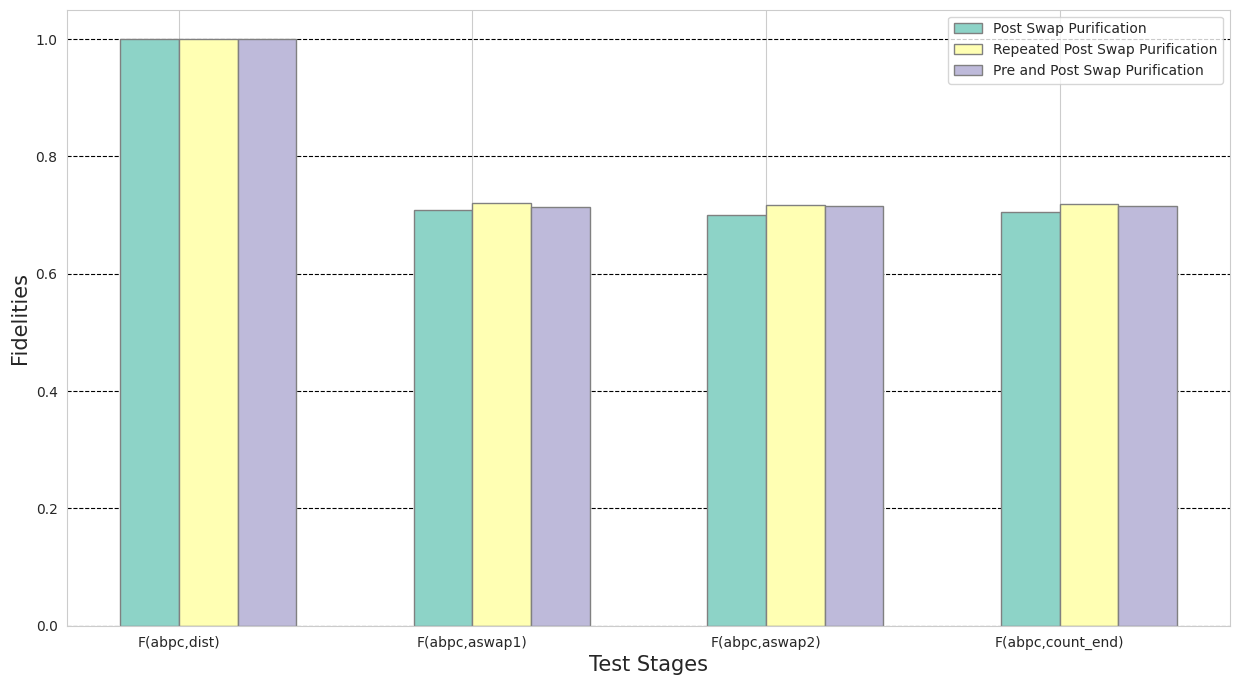

In [49]:
import seaborn as sns  # Import seaborn for color palette

# Set seaborn style
sns.set_style("whitegrid")

# Define data and parameters
bar_width = 0.2
x_axis = np.arange(len(dict_fids_wp))

# Results for different purification strategies
post_swap_results = list(dict_fids_swap.values())
repeated_post_swap_results = list(dict_fids_swaploop.values())
pre_and_post_swap_results = list(dict_fids_swapalt.values())

# Bar positions
bar_positions_post_swap = [k + 1 * bar_width for k in x_axis]
bar_positions_repeated_post_swap = [k + 2 * bar_width for k in x_axis]
bar_positions_pre_and_post_swap = [k + 3 * bar_width for k in x_axis]

# Seaborn color palette
colors = sns.color_palette("Set3")
# colors = ["#2ecc71", "#27ae60", "#16a085"]
# colors = ["#9b59b6", "#8e44ad", "#34495e"]
# colors = ["#3498db", "#2980b9", "#2c3e50"]

# Bar plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(bar_positions_post_swap, post_swap_results, width=bar_width, color=colors[0], edgecolor="grey", label="Post Swap Purification")
ax.bar(bar_positions_repeated_post_swap, repeated_post_swap_results, width=bar_width, color=colors[1], edgecolor="grey", label="Repeated Post Swap Purification")
ax.bar(bar_positions_pre_and_post_swap, pre_and_post_swap_results, width=bar_width, color=colors[2], edgecolor="grey", label="Pre and Post Swap Purification")

# Grid settings
ax.grid(visible=True, axis="y", linestyle="--", color="black")

# Axis labels and ticks
ax.set_ylabel("Fidelities", fontweight="normal", fontsize=15)
ax.set_xlabel("Test Stages", fontweight="normal", fontsize=15)
ax.set_xticks([k + 1.5 * bar_width for k in x_axis])
ax.set_xticklabels(list(dict_fids_wp.keys()))

# Title
# ax.set_title("Impact of Purification on Fidelity at Specific Stages in a Quantum Repeater Protocol", fontweight="bold", fontsize=15)

# Legend
ax.legend()

plt.show()


In [50]:
fig.savefig('deutsch_purification_strategy_simple.jpg', dpi=500, bbox_inches='tight')

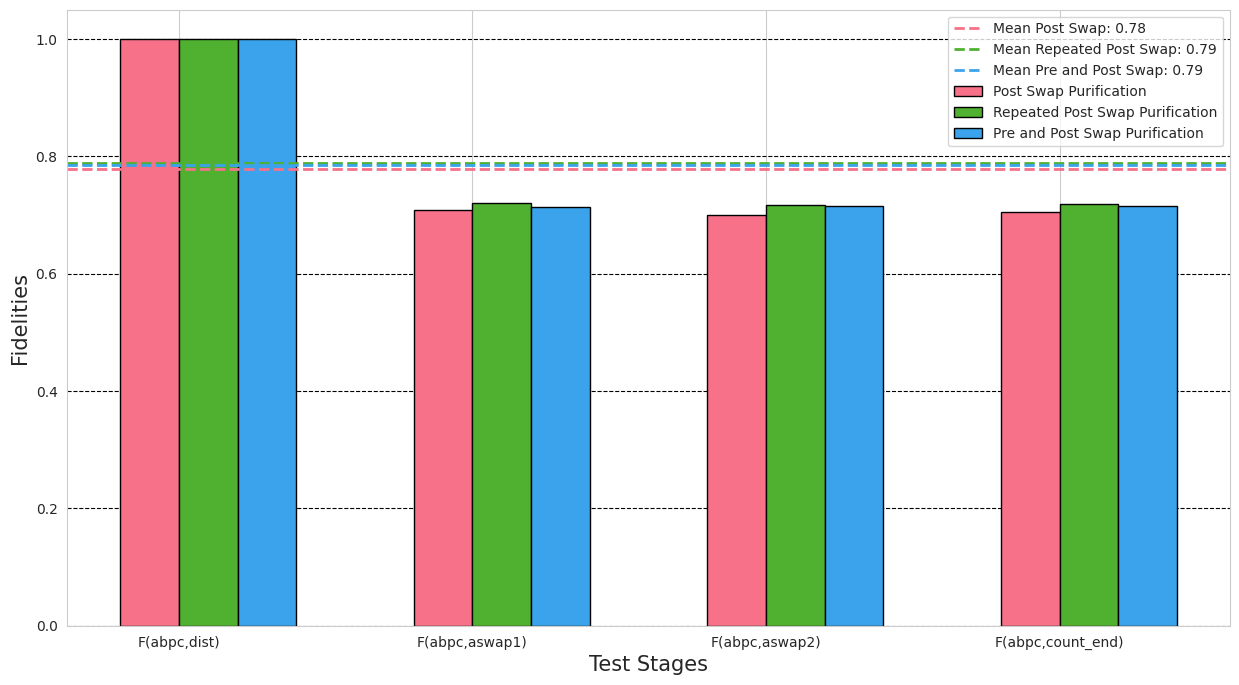

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Assuming dict_fids_wp, dict_fids_swap, dict_fids_swaploop, and dict_fids_swapalt are defined

# Set seaborn style
sns.set_style("whitegrid")

# Define data and parameters
bar_width = 0.2
x_axis = np.arange(len(dict_fids_wp))

# Results for different purification strategies
post_swap_results = list(dict_fids_swap.values())
repeated_post_swap_results = list(dict_fids_swaploop.values())
pre_and_post_swap_results = list(dict_fids_swapalt.values())

# Calculate mean fidelities and standard deviations for each purification strategy
mean_post_swap = np.mean(post_swap_results)
mean_repeated_post_swap = np.mean(repeated_post_swap_results)
mean_pre_and_post_swap = np.mean(pre_and_post_swap_results)

std_post_swap = np.std(post_swap_results)
std_repeated_post_swap = np.std(repeated_post_swap_results)
std_pre_and_post_swap = np.std(pre_and_post_swap_results)

# Perform pairwise t-tests
_, p_value_post_vs_repeated = ttest_ind(post_swap_results, repeated_post_swap_results)
_, p_value_post_vs_pre_and_post = ttest_ind(post_swap_results, pre_and_post_swap_results)
_, p_value_repeated_vs_pre_and_post = ttest_ind(repeated_post_swap_results, pre_and_post_swap_results)

# Bar positions
bar_positions_post_swap = [k + 1 * bar_width for k in x_axis]
bar_positions_repeated_post_swap = [k + 2 * bar_width for k in x_axis]
bar_positions_pre_and_post_swap = [k + 3 * bar_width for k in x_axis]

# Seaborn color palette
colors = sns.color_palette("husl", 3)  # Using the 'husl' color palette for better visibility

# Bar plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(bar_positions_post_swap, post_swap_results, width=bar_width, color=colors[0], edgecolor="black", label="Post Swap Purification")
ax.bar(bar_positions_repeated_post_swap, repeated_post_swap_results, width=bar_width, color=colors[1], edgecolor="black", label="Repeated Post Swap Purification")
ax.bar(bar_positions_pre_and_post_swap, pre_and_post_swap_results, width=bar_width, color=colors[2], edgecolor="black", label="Pre and Post Swap Purification")

# Add mean lines and error bars
ax.axhline(mean_post_swap, color=colors[0], linestyle="--", linewidth=2, label=f'Mean Post Swap: {mean_post_swap:.2f}')
ax.axhline(mean_repeated_post_swap, color=colors[1], linestyle="--", linewidth=2, label=f'Mean Repeated Post Swap: {mean_repeated_post_swap:.2f}')
ax.axhline(mean_pre_and_post_swap, color=colors[2], linestyle="--", linewidth=2, label=f'Mean Pre and Post Swap: {mean_pre_and_post_swap:.2f}')

# ax.errorbar(bar_positions_post_swap, post_swap_results, yerr=std_post_swap, fmt='none', color=colors[0], capsize=5, label=f'Std Dev Post Swap: {std_post_swap:.2f}')
# ax.errorbar(bar_positions_repeated_post_swap, repeated_post_swap_results, yerr=std_repeated_post_swap, fmt='none', color=colors[1], capsize=5, label=f'Std Dev Repeated Post Swap: {std_repeated_post_swap:.2f}')
# ax.errorbar(bar_positions_pre_and_post_swap, pre_and_post_swap_results, yerr=std_pre_and_post_swap, fmt='none', color=colors[2], capsize=5, label=f'Std Dev Pre and Post Swap: {std_pre_and_post_swap:.2f}')

# Grid settings
ax.grid(visible=True, axis="y", linestyle="--", color="black")

# Axis labels and ticks
ax.set_ylabel("Fidelities", fontweight="normal", fontsize=15)
ax.set_xlabel("Test Stages", fontweight="normal", fontsize=15)
ax.set_xticks([k + 1.5 * bar_width for k in x_axis])
ax.set_xticklabels(list(dict_fids_wp.keys()))

# Title
# ax.set_title("Impact of Purification on Fidelity at Specific Stages in a Quantum Repeater Protocol", fontweight="bold", fontsize=15)

# Statistical tests annotations
# ax.annotate(f'p={p_value_post_vs_repeated:.3f}', xy=(1.5, 0.5), xytext=(1.5, 0.7), arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f'p={p_value_post_vs_pre_and_post:.3f}', xy=(2.5, 0.5), xytext=(2.5, 0.7), arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(f'p={p_value_repeated_vs_pre_and_post:.3f}', xy=(3.5, 0.5), xytext=(3.5, 0.7), arrowprops=dict(facecolor='black', shrink=0.05))

# Legend
ax.legend()

# # Additional Plot: Significance of Differences
# fig, ax_sig = plt.subplots(figsize=(10, 6))

# # Plotting significance bars
# ax_sig.bar([1, 2, 3], [p_value_post_vs_repeated, p_value_post_vs_pre_and_post, p_value_repeated_vs_pre_and_post], color=['#ff7f0e', '#2ca02c', '#9467bd'])
# # ax_sig.axhline(0.05, linestyle='--', color='black', linewidth=1, label='Significance Threshold (p=0.05)')
# ax_sig.axhline(0.05, color='red', linestyle='--', linewidth=2, label='Significance Threshold (p=0.05)')

# # Setting labels and title
# ax_sig.set_ylabel('p-value')
# # ax_sig.set_title('Statistical Significance of Differences Between Purification Strategies')
# ax_sig.set_xticks([1, 2, 3])
# ax_sig.set_xticklabels(['Post vs. Repeated', 'Post vs. Pre and Post', 'Repeated vs. Pre and Post'])
# ax_sig.legend()

# # Additional Plot: Box Plot for Fidelities
# fig, ax_box = plt.subplots(figsize=(10, 6))

# # Box plot
# sns.boxplot(data=[post_swap_results, repeated_post_swap_results, pre_and_post_swap_results], width=0.5, palette=colors, ax=ax_box)
# ax_box.set_xticklabels(['Post Swap', 'Repeated Post Swap', 'Pre and Post Swap'])
# ax_box.set_ylabel('Fidelities')
# # ax_box.set_title('Distribution of Fidelities for Each Purification Strategy')

plt.show()


In [52]:
fig.savefig('deutsch_purification_strategy_detailed.jpg', dpi=500, bbox_inches='tight')

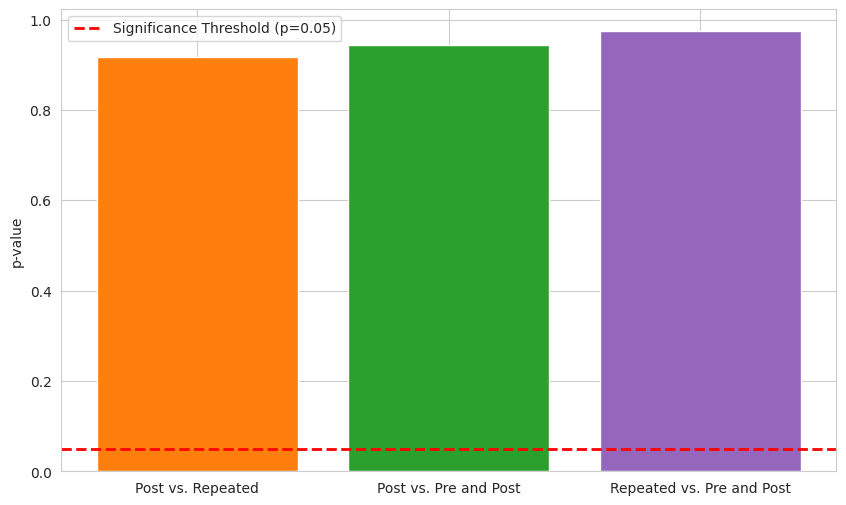

In [53]:
# Additional Plot: Significance of Differences
fig, ax_sig = plt.subplots(figsize=(10, 6))

# Plotting significance bars
ax_sig.bar([1, 2, 3], [p_value_post_vs_repeated, p_value_post_vs_pre_and_post, p_value_repeated_vs_pre_and_post], color=['#ff7f0e', '#2ca02c', '#9467bd'])
# ax_sig.axhline(0.05, linestyle='--', color='black', linewidth=1, label='Significance Threshold (p=0.05)')
ax_sig.axhline(0.05, color='red', linestyle='--', linewidth=2, label='Significance Threshold (p=0.05)')

# Setting labels and title
ax_sig.set_ylabel('p-value')
# ax_sig.set_title('Statistical Significance of Differences Between Purification Strategies')
ax_sig.set_xticks([1, 2, 3])
ax_sig.set_xticklabels(['Post vs. Repeated', 'Post vs. Pre and Post', 'Repeated vs. Pre and Post'])
ax_sig.legend()

plt.show()

In [54]:
fig.savefig('deutsch_purification_strategy_stat_significance.jpg', dpi=500, bbox_inches='tight')

## Correlation Analysis:
### You can explore whether there's a correlation between the fidelity at different stages or between different purification strategies. This can be visualized using a heatmap.

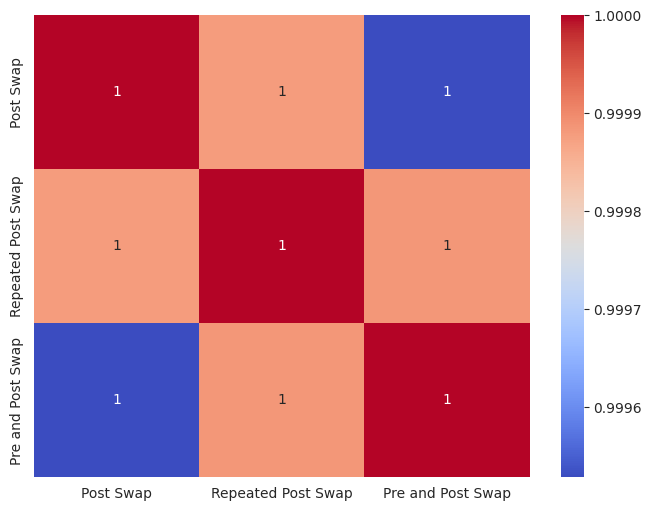

In [55]:
# Assuming dict_fids_corr is a dictionary of correlations between different stages/strategies
correlation_matrix = np.corrcoef([post_swap_results, repeated_post_swap_results, pre_and_post_swap_results])

# Plotting the correlation heatmap
fig, ax_corr = plt.subplots(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=['Post Swap', 'Repeated Post Swap', 'Pre and Post Swap'], yticklabels=['Post Swap', 'Repeated Post Swap', 'Pre and Post Swap'])
# ax_corr.set_title('Correlation Between Fidelity at Different Stages/Strategies')
plt.show()


In [56]:
fig.savefig('deutsch_purification_strategy_correlation.jpg', dpi=500, bbox_inches='tight')

## Box Plot
### Use a box plot to visualize the distribution of fidelities for each purification strategy, providing insights into the spread of data and potential outliers.

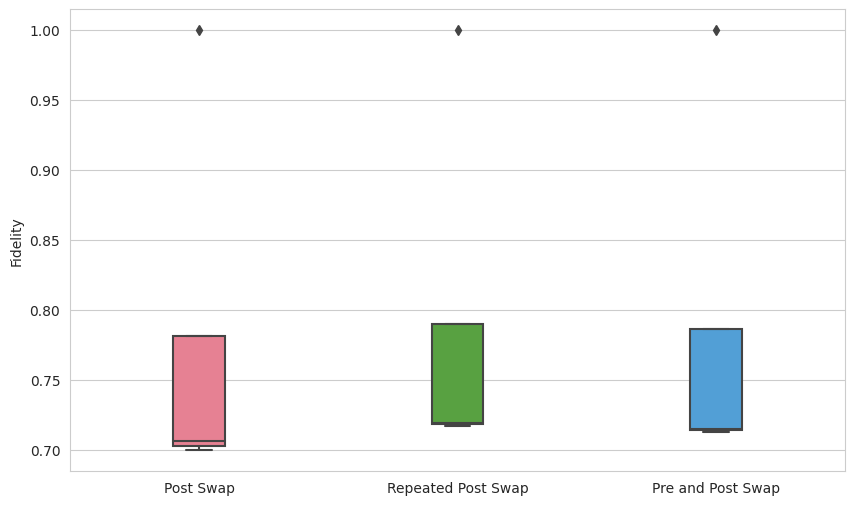

In [57]:


# Assuming dict_fids_box is a dictionary of fidelity values for each strategy
fig, ax_box = plt.subplots(figsize=(10, 6))
sns.boxplot(data=[post_swap_results, repeated_post_swap_results, pre_and_post_swap_results], width=0.2, palette=colors, ax=ax_box)
ax_box.set_xticklabels(['Post Swap', 'Repeated Post Swap', 'Pre and Post Swap'])
ax_box.set_ylabel('Fidelity')
# ax_box.set_title('Distribution of Fidelities for Each Purification Strategy')
plt.show()


In [58]:
fig.savefig('deutsch_purification_strategy_fidelity_distribution.jpg', dpi=500, bbox_inches='tight')